This code performs principal component regression (PCR) on 2D spectral data obtained from fluorescence spectra of combustion generated particles.

The 2D spectra are called excitation emission matrices (EEMs). Each EEM is a sample in X. 

The Y for each EEM are conentration levels of 16 priority toxic compounds found in combustion generated air pollution particles. 

In [2]:
# Make all numpy available via shorter 'num' prefix

import numpy as np
import numpy.matlib as M
from numpy.matlib import rand,zeros,ones,empty,eye
import matplotlib as mpl
from scipy import linalg
from scipy import misc
from sklearn import mixture
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import genfromtxt
from sklearn import mixture
from pylab import *
from sklearn.decomposition import PCA
from pandas import DataFrame
from sklearn import linear_model
import statsmodels.api as sm

from itertools import cycle, islice
import pandas

np.random.seed(3)

In [2]:
# Load 100 samples and their labels
    
X_train = np.genfromtxt("./xtrain.csv", dtype=float, delimiter=',') 
X_test = np.genfromtxt("./xtest.csv", dtype=float, delimiter=',') 
Y_train = np.genfromtxt("./ytrain.csv", dtype=float, delimiter=',') 
Y_test = np.genfromtxt("./ytest.csv", dtype=float, delimiter=',') 

In [3]:
# Load excitation wavelength and emission wavelength data

Ex = np.genfromtxt('./20samples Original/Ex.csv', dtype=float, delimiter=',')
Em = np.genfromtxt('./20samples Original/Em.csv', dtype=float, delimiter=',')

# Import names of toxic compounds (PAHs)

df = pandas.read_csv('./20labels Original/PAHs.csv')
index_col='Acronyms'
leg = df[index_col][:16]
lst = list(leg)

In [4]:
# Reduce the size of Ex and Em to match that of the EEMs for plotting

fsize = 33
n = int(np.around(Ex.size/fsize))
Ex_new = zeros(fsize)
for i in range(fsize):
    Ex_new[i] = np.mean(Ex[i*n+1:(i+1)*n])
    
fsize = 100
n = int(np.around(Em.size/fsize))
Em_new = zeros(fsize)
for i in range(fsize):
    Em_new[i] = np.mean(Em[i*n+1:(i+1)*n])


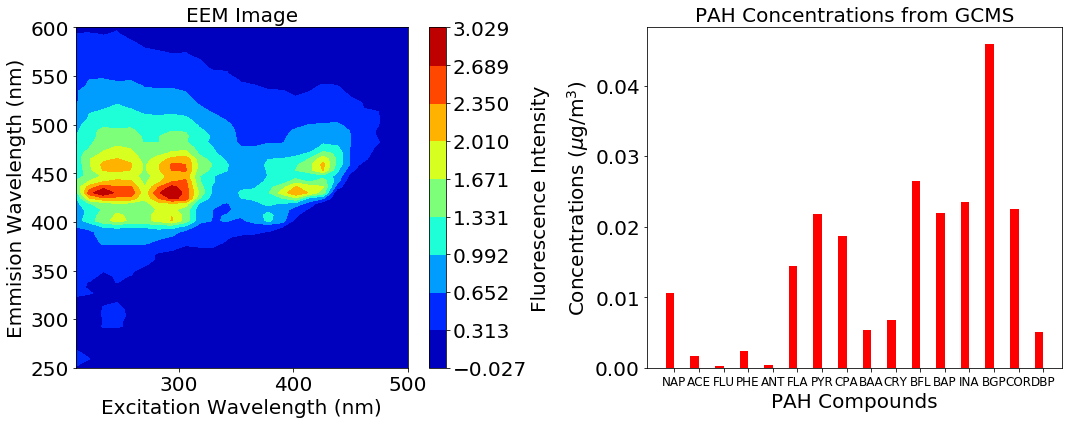

In [5]:
# Example EEM Xi and its corresponding 16 toxic compound concentration Yi

from matplotlib import cm
mpl.rc('image', cmap='jet')

f1 = plt.figure(figsize=(15,6))

levels=linspace(min(X_train[25,:]),max(X_train[25,:]),10)
ax = f1.add_subplot(1,2,1)
eem = np.reshape(X_train[25,:],(100,33))
cont = ax.contourf(Ex_new,Em_new,eem,levels)
ax.set_xlim([210,500])
ax.set_ylim([250,600])
ax.set_title('EEM Image',fontsize=20)
ax.set_ylabel('Emmision Wavelength (nm)',fontsize=20)
ax.set_xlabel('Excitation Wavelength (nm)',fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
cbar = f1.colorbar(cont)
cbar.ax.set_ylabel('Fluorescence Intensity',fontsize=20)
cbar.ax.tick_params(axis='y', labelsize=20)

ax = f1.add_subplot(1,2,2)
df1 = ax.bar(np.arange(16),Y_train[25,:],0.35,color='red',label='Test Samples Original')
ax.set_ylabel('Concentrations ($\mu$g/m$^{3}$)',fontsize=20)
ax.set_xlabel('PAH Compounds',fontsize=20)
ax.set_xticks(np.arange(16)+0.35*np.ones(16)/2)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=20)
ax.set_xticklabels(lst)
ax.set_title('PAH Concentrations from GCMS',fontsize=20)
    
    
plt.tight_layout()
plt.show()


In [6]:
# Demean X data

M = X_train.mean(0)
X_train = X_train - np.array([M,]*600)

X_test = X_test - np.array([M,]*150)

In [7]:
# Perform PCA

from sklearn.decomposition import PCA

pca = PCA()  
scores = pca.fit_transform(X_train)  
comps = pca.components_

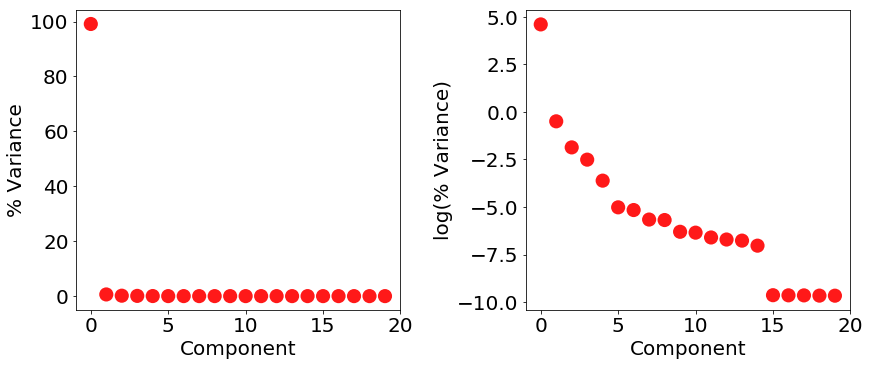

In [8]:
# Variance plot for PCA

D = pca.explained_variance_
f2 = plt.figure(figsize=(12,5))
ax = f2.add_subplot(1,2,1)
ax.scatter(range(20),100*np.divide(D[:20],sum(D[:20])),s=200,marker="o",c='r',alpha=0.9,edgecolors='none')
ax.set_ylabel('% Variance',fontsize=20)
ax.set_xlabel('Component',fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

ax2 = f2.add_subplot(1,2,2)
ax2.scatter(range(20),log(100*np.divide(D[:20],sum(D[:20]))),s=200,marker="o",c='r',alpha=0.9,edgecolors='none')
ax2.set_ylabel('log(% Variance)',fontsize=20)
ax2.set_xlabel('Component',fontsize=20)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)
    
plt.show()

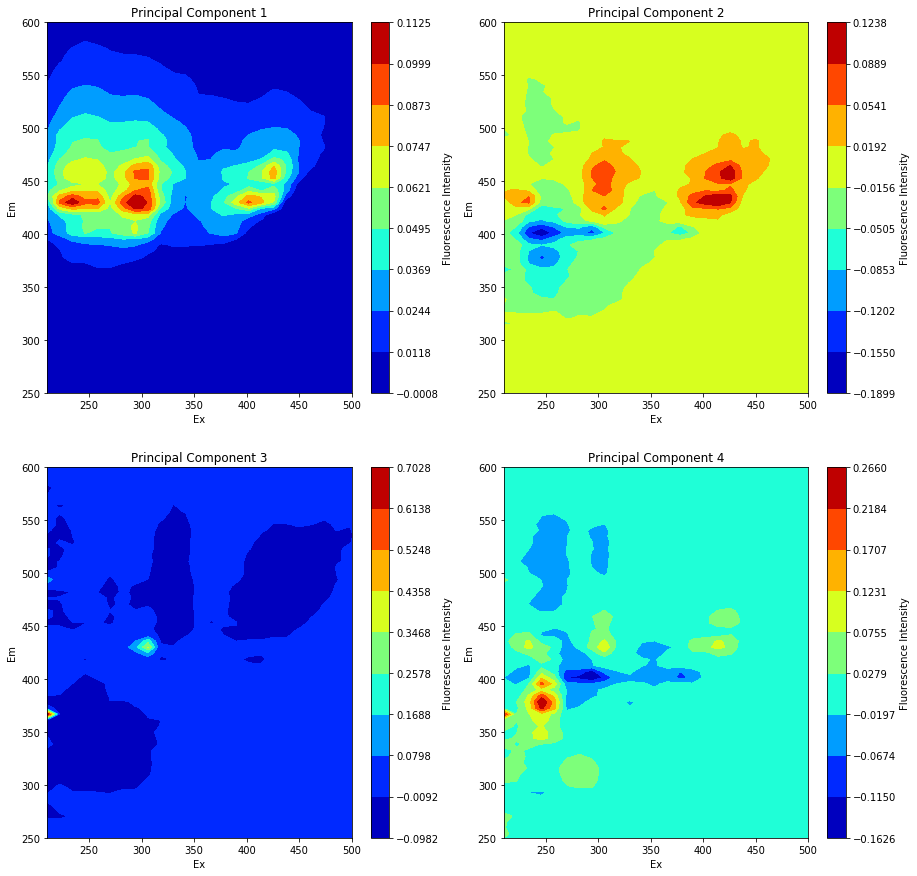

In [42]:
# Plotting first four principal components

f2 = plt.figure(figsize=(15,15))
for i in range(4):
    levels=linspace(min(comps[i,:]),max(comps[i,:]),10)
    ax = f2.add_subplot(2,2,i+1)
    eem = np.reshape(comps[i,:],(100,33))
    cont = ax.contourf(Ex_new,Em_new,eem,levels)
    ax.set_xlim([210,500])
    ax.set_ylim([250,600])
    ax.set_title('Principal Component %s' %(i+1))
    ax.set_ylabel('Em')
    ax.set_xlabel('Ex')
    cbar = f2.colorbar(cont)
    cbar.ax.set_ylabel('Fluorescence Intensity')

plt.show()

In [9]:
scores_test = pca.transform(X_test)  

In [10]:
# Fitting a linear model and validating using test data

pca_dim = 10

regr = linear_model.LinearRegression()
xtrain = scores[:,:pca_dim]
ytrain = Y_train
xtest = scores_test[:,:pca_dim]
ytest = Y_test
lm = linear_model.LinearRegression()
model = lm.fit(xtrain,ytrain)

ypred_train = lm.predict(xtrain)

err = np.zeros((ytrain[:,0].size,ytrain[0,:].size))
for i in range(ytrain[:,0].size):
    for j in range(ytrain[0,:].size):
        err[i,j] = np.absolute(ytrain[i,j]-ypred_train[i,j])
err_train = 100*np.divide(np.sum(err,axis=0),np.sum(ytrain,axis=0))
    
    
            
ypred_test = lm.predict(xtest)

err = np.zeros((ytest[:,0].size,ytest[0,:].size))
for i in range(ytest[:,0].size):
    for j in range(ytest[0,:].size):
        err[i,j] = np.absolute(ytest[i,j]-ypred_test[i,j])
err_test = 100*np.divide(np.sum(err,axis=0),np.sum(ytest,axis=0))

In [11]:
# Training error for prediction of 16 toxic compound concentration levels.
err_train

array([12.57615421,  9.59507324,  7.07625439,  3.13251228,  4.16792905,
        4.86052702,  4.3748847 ,  1.54698065,  2.22858737,  2.89504842,
        1.14162107,  0.604353  ,  0.23834336,  0.33130713,  0.27622887,
        0.3557938 ])

In [46]:
# Test error for prediction of 16 toxic compound concentration levels.
err_test

array([69.4209389 , 49.19431667, 21.65184485, 14.72173566, 16.7843381 ,
       63.80702992, 57.96948672, 26.39430561, 51.87960832, 44.56747963,
       20.42010967, 16.83918417, 15.77321208, 14.31729285, 29.97403425,
       16.16199521])

In [12]:
# Total average test error over all 16 compounds
sum(err_test)/16

33.117307037953026

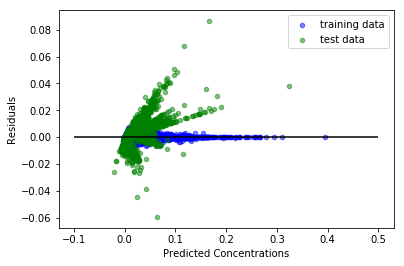

In [48]:
# Checking residual error to check linearity of the model

plt.scatter(ypred_train,ypred_train-ytrain,c='b',s=20,alpha=0.5)
plt.scatter(ypred_test,ypred_test-ytest,c='g',s=20,alpha=0.5)
plt.hlines(y=0,xmin=-0.1,xmax=0.5)
plt.xlabel('Predicted Concentrations')
plt.ylabel('Residuals')
plt.legend(['training data','test data'])

In [13]:
# Test R square
lm.score(xtest,ytest)

0.7875505073722981

In [18]:
# zero negative predictions
for i in range(ypred_train[:,0].size):
    for j in range(ypred_train[0,:].size):
        if ypred_train[i,j] < 0:
            ypred_train[i,j]=0
            
for i in range(ypred_test[:,0].size):
    for j in range(ypred_test[0,:].size):
        if ypred_test[i,j] < 0:
            ypred_test[i,j]=0

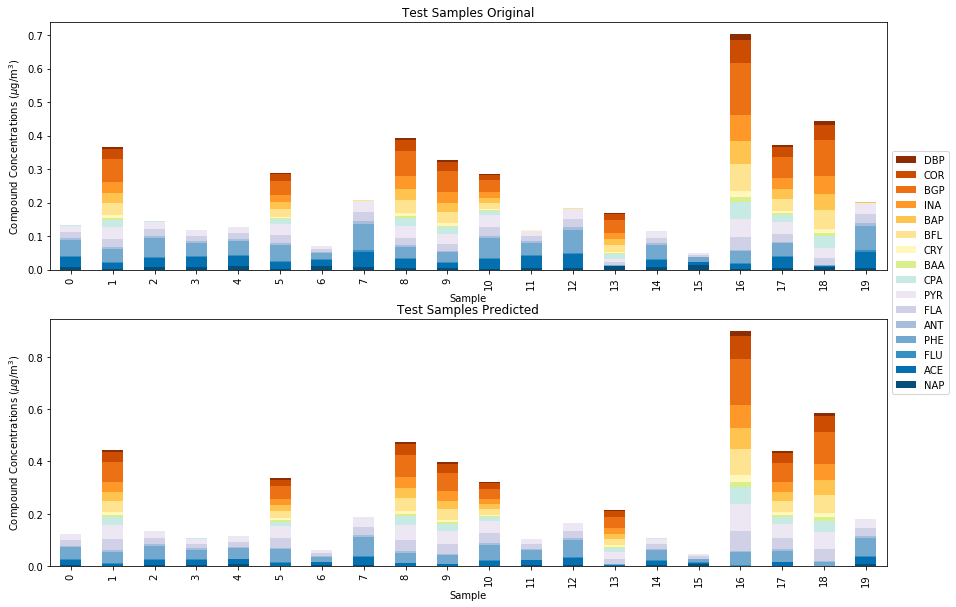

In [55]:
# Comparing original and test results

col = [(3,78,123),
(5,112,176),
(54,144,192),
(116,169,207),
(166,189,219),
(208,209,230),
(236,231,242),
(199,234,229),
(217,239,139),
(255,247,188),
(254,227,145),
(254,196,79),
(254,153,41),
(236,112,20),
(204,76,2),
(140,45,4)]
col = np.divide(col,255);

f3 = plt.figure(figsize=(15,10))
ax1 = f3.add_subplot(2,1,1)
df1 = pandas.DataFrame(ytest[:20,:])
df1.plot(kind='bar', stacked=True, color=col,ax=ax1)
ax1.set_title('Test Samples Original')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(reversed(handles), reversed(lst), loc='upper left',bbox_to_anchor=(1, 0.5))
ax1.set_ylabel('Compound Concentrations ($\mu$g/m$^{3}$)')
ax1.set_xlabel('Sample')

ax2 = f3.add_subplot(2,1,2)
df2 = pandas.DataFrame(ypred_test[:20,:])
df2.plot(kind='bar', stacked=True, color=col,ax=ax2,legend='False')
ax2.set_title('Test Samples Predicted',)
ax2.set_ylabel('Compound Concentrations ($\mu$g/m$^{3}$)')
ax2.set_xlabel('Sample')
ax2.get_legend().remove()

#ax.set_xlim([200,500])
#ax.set_ylim([250,600])
#ax.set_title('Principal Component %s' %(i+1))
#ax.set_ylabel('Em')
#ax.set_xlabel('Ex')
#cbar = f2.colorbar(cont)
#cbar.ax.set_ylabel('Fluorescence Intensity')

C:\Users\IVN\Anaconda2\envs\py35\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. Please call randint(0, 149 + 1) instead
  


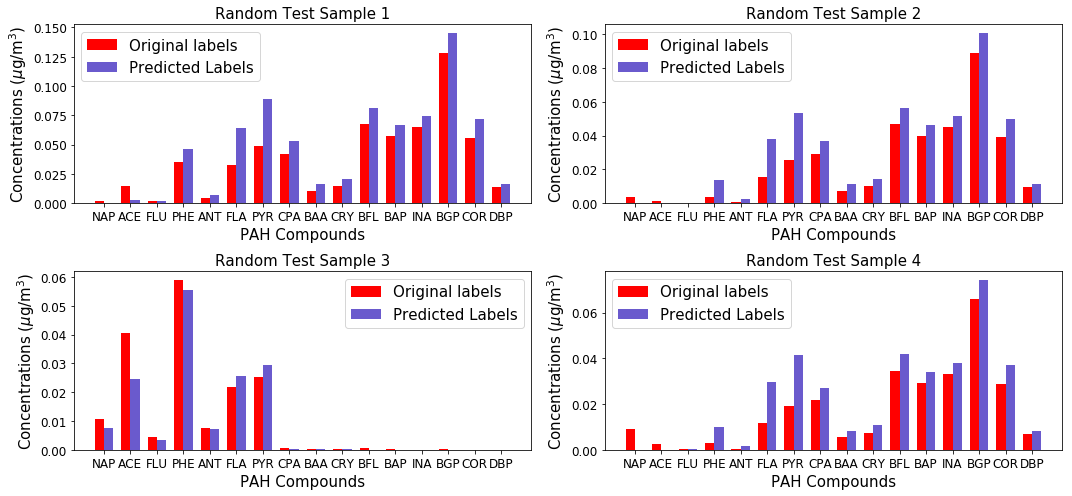

In [22]:
# Plotting results


from matplotlib.ticker import MaxNLocator
from collections import namedtuple

np.random.seed(6)
idr=np.random.random_integers(0,ytest[:,0].size-1,size=(4,))

f4 = plt.figure(figsize=(15,7))
ax = [f4.add_subplot(2,2,i+1) for i in range(4)]
i=0;    
for a in ax:
    df1 = a.bar(np.arange(16),ytest[idr[i],:],0.35,color='red',label='Test Samples Original')
    df2 = a.bar(np.arange(16)+0.35*np.ones(16),ypred_test[idr[i],:],0.35,color='slateblue',label='Test Samples Predicted')
    a.set_ylabel('Concentrations ($\mu$g/m$^{3}$)',fontsize=15)
    a.set_xlabel('PAH Compounds',fontsize=15)
    a.set_xticks(np.arange(16)+0.35*np.ones(16)/2)
    a.tick_params(axis='x', labelsize=12)
    a.tick_params(axis='y', labelsize=12)
    a.set_xticklabels(lst)
    a.set_title('Random Test Sample %s' %(i+1),fontsize=15)
    a.legend(('Original labels','Predicted Labels'),fontsize=15)
    i=i+1
plt.tight_layout()


In [58]:
# Error from neural network approach (code not included)
neural_test_err = np.array([ 66.13174493,  51.18761333,  94.7017307 ,  59.71304314,
       142.54436817,  80.43994284,  53.01078864,  86.28619464,
        75.66064477,  91.42608545, 104.30913994,  95.61119955,
        84.03079641,  93.71643637,  76.94555714, 107.46187003])


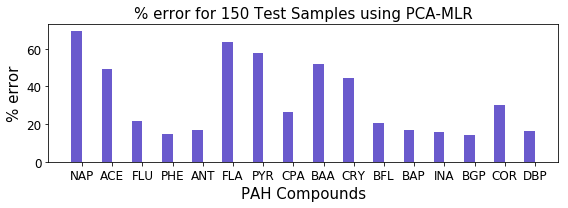

In [59]:
# Plotting error for prediction of 16 compound concentration levels using PCR

f5 = plt.figure(figsize=(8,3))
ax = f5.add_subplot(1,1,1)

df1 = ax.bar(np.arange(16),err_test,0.35,color='slateblue',label='Test Samples Original')
ax.set_ylabel('% error',fontsize=15)
ax.set_xlabel('PAH Compounds',fontsize=15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(np.arange(16)+0.35*np.ones(16)/2)
ax.set_xticklabels(lst)
ax.set_title('% error for 150 Test Samples using PCA-MLR',fontsize=15)
plt.tight_layout()


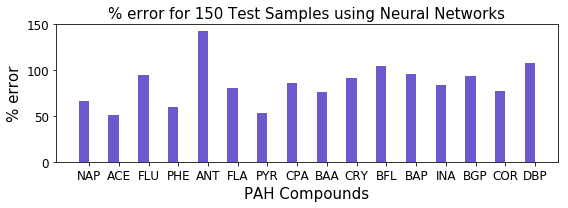

In [60]:
# Plotting error for prediction of 16 compound concentration levels using neural network. 


f5 = plt.figure(figsize=(8,3))
ax = f5.add_subplot(1,1,1)

df1 = ax.bar(np.arange(16),neural_test_err,0.35,color='slateblue',label='Test Samples Original')
ax.set_ylabel('% error',fontsize=15)
ax.set_xlabel('PAH Compounds',fontsize=15)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(np.arange(16)+0.35*np.ones(16)/2)
ax.set_xticklabels(lst)
ax.set_title('% error for 150 Test Samples using Neural Networks',fontsize=15)
plt.tight_layout()


In [20]:
# Plot parity plots for prediction of each of the 16 compounds

def parity_plots(y_test, pred_test,
                 y_train=None, pred_train=None,
                titles = None):
    """Make parity plots for  16 regression outputs
    **In the future make it so any number of parity plots can be accomidate
    Args:
        y_test (np.array): expected values for test dataset 
            (shape = samples X values, currently expected as samples X 16) 
        pred_test (np.array): predicted values from test dataset
        y_train (np.array, optional): expected values from test dataset 
        pred_test (np.array, optional): predicted values from test dataset
        titles (list of strings, optional) : list of strings to use as tiles on plots
    
    Returns:
        fig: (matplotlib.figure.Figure) : Parity Plots
    """
    
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    from sklearn.metrics import r2_score
    
   
    # Define colors for test and train
    # http://colorbrewer2.org/#type=qualitative&scheme=Set1&n=3
    c_low = [55 / 255, 126 / 255, 184 / 255]
    c_high = [228 / 255, 26 / 255, 28 / 255]
    c_train = [77 / 255, 175 / 255, 74 / 255, 0.4]
       
    fig = plt.figure(figsize=(15, 21))
    
    outer = gridspec.GridSpec(4, 4, wspace=0.5, hspace=0.2)
    
    
    # Generate a parity plot for each class using a loop
    for i in range(0, pred_test.shape[1]):
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.4,
                                                height_ratios=[3,1])
        
        #first axis - parity plot
        ax = plt.Subplot(fig, inner[0])
        
        # calculate appropriate scale for x and y axis
        maximums = [np.max(pred_test[:, i]), np.max(y_test[:, i])] 
        minimums = [np.min(pred_test[:, i]), np.min(y_test[:, i])]
        #ax_max = np.max(maximums)
        #ax_min = np.min(minimums)
        ax_min = 0.0
        ax_max = 0.15
        ax_range = ax_max - ax_min
        #add some padding so no data are on the edges
        ax_max = ax_max + ax_range*.25
        ax_min = ax_min - ax_range*.25

        # add the training data to the plot
        if y_train is None:
            pass
        else:
            ax.scatter(y_train[:, i], pred_train[:, i], color=c_train)
            
        # plot the test data
        # select blue color for low MW, select red color for high MW
        if i<7:
            color = c_low
        else:
            color = c_high
        ax.scatter(y_test[:, i], pred_test[:, i], color=color)
        # add perfect prediction line
        ax.plot([ax_min, ax_max], [ax_min, ax_max], color='k',
                 label='Perfect Prediction', linewidth=3)
        
        ax.set_ylim(ax_min, ax_max)
        ax.set_xlim(ax_min, ax_max)
        ax.set_xlabel('Actual', fontsize=14)
        ax.set_ylabel('Predicted', fontsize=14)
        ax.tick_params(labelsize=12)
        if titles is None:
            pass
        else:
            ax.set_title(titles[i], fontsize=16, weight='bold')
        # add an option for putting a letter on each plot later
        #         # add letters to each plot
        #         letter = ['A', 'B', 'C']
        #         bbox_props = dict(boxstyle="round, pad=0.1", fc="white", ec="white", lw=2)
        #         plt.text(-0.5, 6.5, letter[i], ha="center", va="center",
        #             size=20,
        #             bbox=bbox_props)     
        fig.add_subplot(ax)
        
        ######## Put R^2 values in the second panel below the plot #########
        ax = plt.Subplot(fig, inner[1])
        
        # Calulate and report R^2 train if training data provided
        if y_train is None:
            pass
        else:
            r2_train = r2_score(y_train[:, i], pred_train[:, i])
            t = ax.text(0.5,0.5, '$R^2$ train = %.3f' % r2_train, size=14)
            t.set_ha('center')
        
        # Calulate and report R^2 test
        r2_test = r2_score(y_test[:, i], pred_test[:, i])
        t = ax.text(0.5, 0.2, '$R^2$ test = %.3f' % r2_test, size=14)
        t.set_ha('center')
        fig.add_subplot(ax)
        
        #hide the axis
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')

    return fig



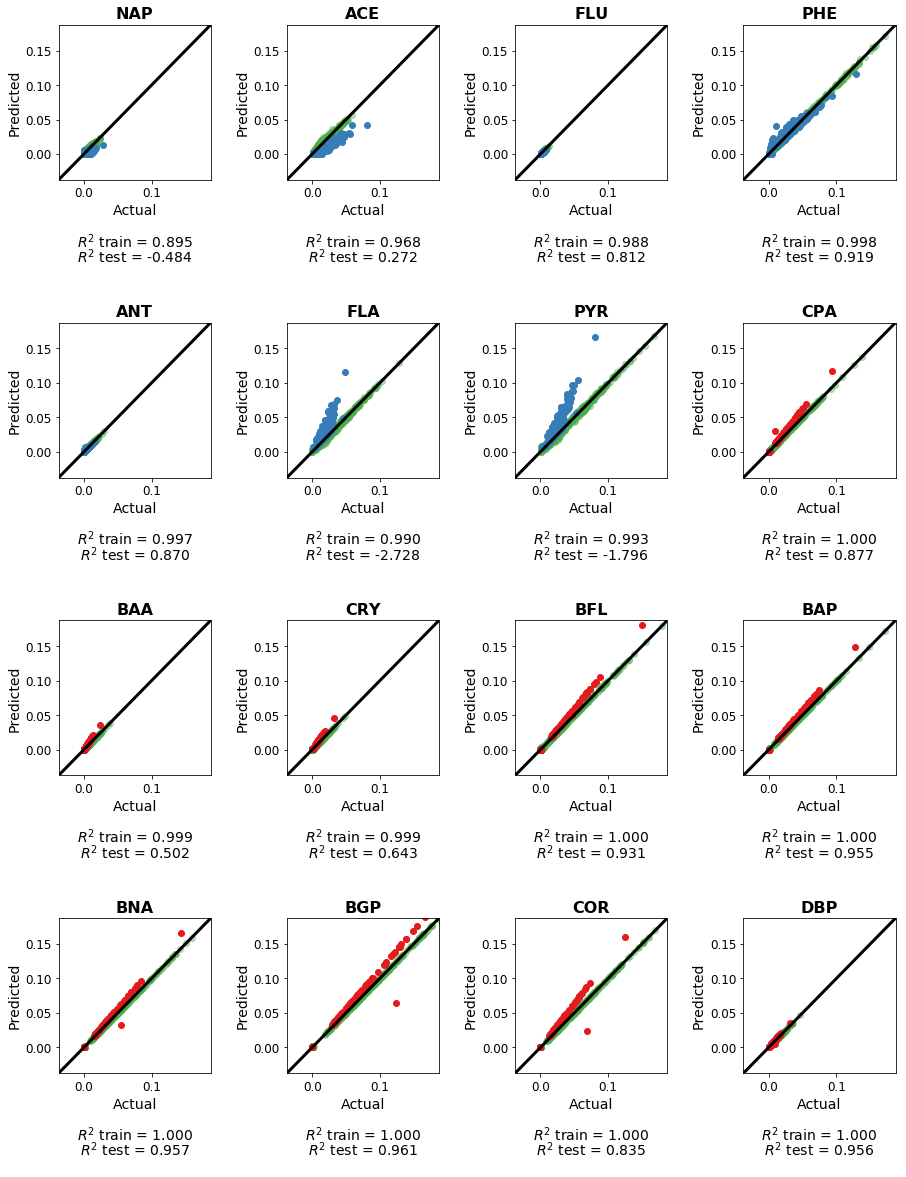

In [24]:
titles = ['NAP','ACE','FLU','PHE', 'ANT', 'FLA', 'PYR',
          'CPA','BAA','CRY','BFL','BAP','BNA',
         'BGP','COR','DBP']

fig = parity_plots(ytest, ypred_test, ytrain, ypred_train, titles=titles)
fig.savefig('C:/Users/IVN/Dropbox/General Exam/ParityPlots.png')